<a href="https://colab.research.google.com/github/tetianasokolova/computer-vision-project/blob/main/Resnet50_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with ResNet50 and Fine-Tuning

Applying transfer learning using the ResNet50 architecture pretrained on ImageNet to improve accuracy.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, zipfile

## Load the dataset Animals-10
Connect to Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip in Colab's temporary storage
zip_path = "/content/drive/MyDrive/CVDL/Data/Animals-10.zip"
data_path = "/content/raw-img"  # Extract in Colab's temporary storage

if not os.path.exists(data_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")  # Extract directly to /content/

In [ ]:
# Load the data
data = datasets.ImageFolder(root=data_path)

There are 26,179 images in Animal-10 dataset.

In [ ]:
len(data)

26179

Check classes of the data. We see that there are 10 classes of animals.

In [ ]:
# Check class-to-index mapping
data.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Translate classes names from Italian to English using dictionary from Python file in the data archiv.

In [ ]:
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca": "cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

In [ ]:
data.classes = [translate.get(name, name) for name in data.classes]
data.class_to_idx = {name: idx for idx, name in enumerate(data.classes)}

In [ ]:
data.classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

## Split data into train, validation and test
60% - train data, 20% - validation data and 20% - test data. Do stratified split, to ensure the same proportion of images for each class.

In [ ]:
# Extract labels for stratification
labels = np.array(data.targets)

# Split into 80% (train+val) and 20% (test)
train_val_idx, test_idx = train_test_split(
    np.arange(len(data)), test_size=0.2, random_state=42, shuffle=True, stratify=labels
)

# Split 80% (train+val) into 60% train and 20% validation
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.25, random_state=42, shuffle=True, stratify=labels[train_val_idx]
)
# test_size=0.25 ensures val is 20% of total data (20% / 80% = 0.25)

# Create Subsets
train_ds = Subset(data, train_idx)
val_ds = Subset(data, val_idx)
test_ds = Subset(data, test_idx)

In [ ]:
# Print dataset sizes
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Train size: 15707
Validation size: 5236
Test size: 5236


## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5177272, 0.500307 , 0.4125527], std=[0.27112892, 0.26629838, 0.2833791])
])

In [ ]:
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5177272, 0.500307 , 0.4125527], std=[0.27112892, 0.26629838, 0.2833791])
])

Create a class TransformedSubset to apply separate transformation to each subset after split.

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform)
val_ds = TransformedSubset(val_ds, transform=test_val_transform)
test_ds = TransformedSubset(test_ds, transform=test_val_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(15707, 5236, 5236)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## Load pretrained ResNet50

In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


In [ ]:
# Replace final layer of the model
model.fc = nn.Linear(model.fc.in_features, 10)

In [ ]:
# Unfreeze deeper layers early
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True

In [ ]:
# Optimizer with different LRs
fc_params = list(model.fc.parameters())
backbone_params = [p for name, p in model.named_parameters() if "fc" not in name and p.requires_grad]
optimizer = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': fc_params, 'lr': 1e-3}
], weight_decay=1e-4)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Train the model

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels, total_loss = [], [], 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_function(out, y)
            total_loss += loss.item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return total_loss / len(dataloader), accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds, average='weighted')

In [ ]:
# Training loop
epochs = 10
best_val_loss = float('inf')
best_state = None
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = [], [], [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, preds, labels = 0, [], []
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        labels.extend(y.cpu().numpy())

    train_loss = total_loss / len(train_dl)
    train_acc = accuracy_score(labels, preds)
    train_f1 = f1_score(labels, preds, average='weighted')
    val_loss, val_acc, val_f1 = evaluate_model(model, val_dl)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

Epoch 1/10 | Train Loss: 0.2142, Acc: 0.9387, F1: 0.9386 | Val Loss: 0.0815, Acc: 0.9777, F1: 0.9776
Epoch 2/10 | Train Loss: 0.0808, Acc: 0.9750, F1: 0.9750 | Val Loss: 0.0848, Acc: 0.9784, F1: 0.9785
Epoch 3/10 | Train Loss: 0.0568, Acc: 0.9815, F1: 0.9815 | Val Loss: 0.0878, Acc: 0.9803, F1: 0.9803
Epoch 4/10 | Train Loss: 0.0360, Acc: 0.9890, F1: 0.9890 | Val Loss: 0.0891, Acc: 0.9826, F1: 0.9827
Epoch 5/10 | Train Loss: 0.0253, Acc: 0.9918, F1: 0.9918 | Val Loss: 0.0995, Acc: 0.9778, F1: 0.9778
Epoch 6/10 | Train Loss: 0.0138, Acc: 0.9963, F1: 0.9963 | Val Loss: 0.0875, Acc: 0.9824, F1: 0.9824
Epoch 7/10 | Train Loss: 0.0132, Acc: 0.9959, F1: 0.9959 | Val Loss: 0.0873, Acc: 0.9811, F1: 0.9811
Epoch 8/10 | Train Loss: 0.0117, Acc: 0.9962, F1: 0.9962 | Val Loss: 0.0877, Acc: 0.9822, F1: 0.9822
Epoch 9/10 | Train Loss: 0.0093, Acc: 0.9975, F1: 0.9975 | Val Loss: 0.0856, Acc: 0.9822, F1: 0.9822
Epoch 10/10 | Train Loss: 0.0074, Acc: 0.9980, F1: 0.9980 | Val Loss: 0.0876, Acc: 0.9822, 

In [ ]:
torch.save(best_state, "best_resnet50_animals10.pth")

## Visualise train results

We see that the model shows steady improvement over 10 epochs.
- **Training loss** drops from 0.2142 to 0.0074, indicating better learning of the model.
- **Training accuracy** rises from 93.87% to 99.80%, and **validation accuracy** from 97.77% to 98.22%, showing good generalization of the model.
- **Train F1 score** improves from 93.86% to 99.80%, and **validation F1 score** from 97.76% to 98.22%, which suggests balanced precision and recall.

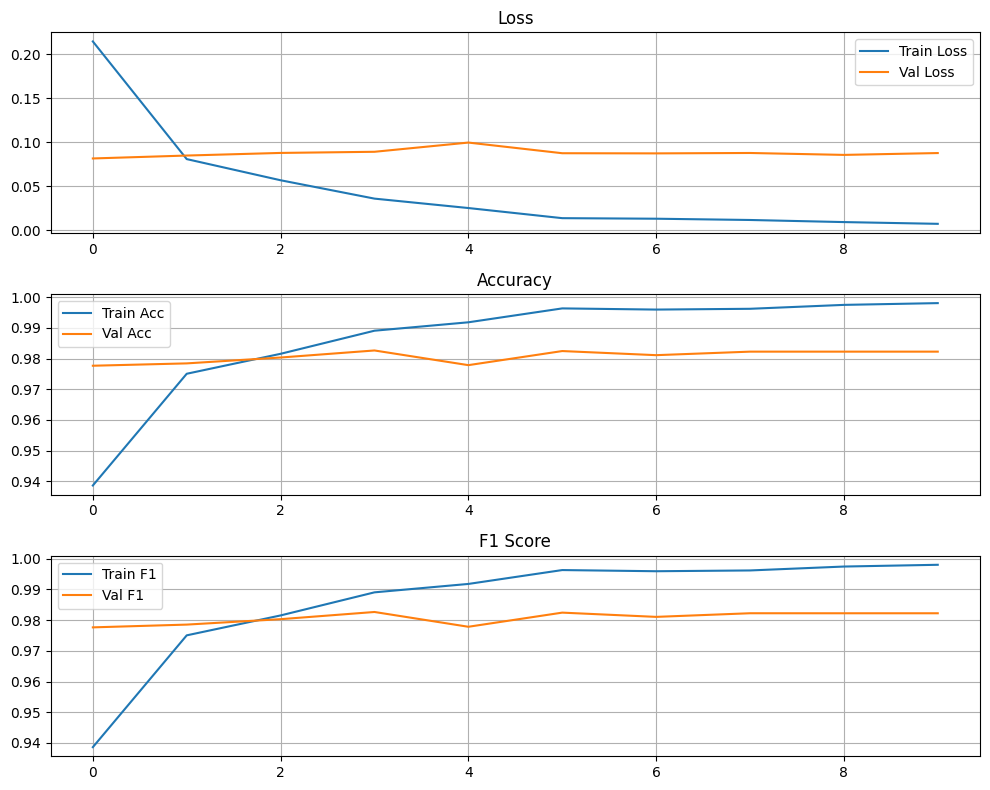

In [ ]:
# Plot training metrics
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.grid(True)
plt.title('Loss')

plt.subplot(3, 1, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.grid(True)
plt.title('Accuracy')

plt.subplot(3, 1, 3)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Val F1')
plt.legend()
plt.grid(True)
plt.title('F1 Score')

plt.tight_layout()
plt.show()

## Evaluate the model on test data

In [ ]:
model.load_state_dict(torch.load("best_resnet50_animals10.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = torch.argmax(out, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=data.classes))

              precision    recall  f1-score   support

         dog       0.98      0.98      0.98       973
       horse       0.98      0.98      0.98       525
    elephant       0.99      0.97      0.98       289
   butterfly       0.98      0.99      0.98       422
     chicken       0.99      0.99      0.99       620
         cat       0.98      0.98      0.98       334
         cow       0.98      0.94      0.96       373
       sheep       0.94      0.97      0.96       364
      spider       1.00      0.99      1.00       964
    squirrel       0.98      0.98      0.98       372

    accuracy                           0.98      5236
   macro avg       0.98      0.98      0.98      5236
weighted avg       0.98      0.98      0.98      5236



- Overall accuracy of 98% on test data indicats very good performance.
- **Best performing classes** are **spider** (F1: 1.00) and **chicken** (F1 score: 0.99).
- **Worst performing classes** are **cow** (F1: 0.96) and **sheep** (F1: 0.96).

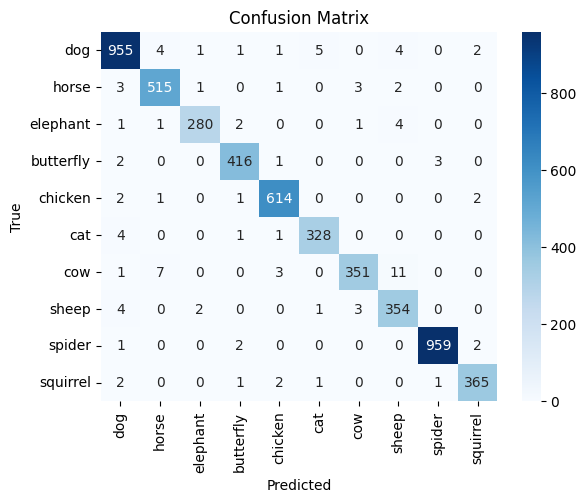

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=data.classes, yticklabels=data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()